# Data

The dataset originates from the National Institute of Diabetes and Digestive and Kidney Diseases. It aims to predict whether a patient has diabetes using diagnostic measurements. The data includes the variables Pregnancies (number of pregnancies), Glucose (Blood glucose level), BloodPressure (Blood Pressure Measurement), SkinThickness (A measure of thickness of skin, zero if missing), Insulin (Insulin in blood level), BMI (Body Mass Index), DiabetesPedigreeFunction (Diabetes percentage likely observed in the patients pedigree), and Age (Age greater than or equal to 21). The final variable Outcome is a dummy varibale (1 for having diabetes, 0 otherwise). Currently, Outcome is represented as an integer but in our data wrangling I plan to change it into a factor variable. Notably, all patients are all female, at least 21 years old, and of Pima Indian heritage. In the data set there are a total of 768 observations. 

| Column                   | Description                                       | Data Type  | Range                      |
|--------------------------|---------------------------------------------------|------------|----------------------------|
| Pregnancies              | Number of pregnancies                             | Integer    | 0 to 17                    |
| Glucose                  | Glucose level in blood (mg/dL)                    | Integer    | 0 to 199                   |
| BloodPressure            | Blood pressure measurement (mm Hg)                | Integer    | 0 to 122                   |
| SkinThickness            | Thickness of the skin (mm)                        | Integer    | 0 to 99                    |
| Insulin                  | Insulin level in blood (mu U/ml)                  | Integer    | 0 to 846                   |
| BMI                      | Body mass index (kg/m^2)                          | Numeric    | 0.0 to 67.1                |
| DiabetesPedigreeFunction| Diabetes percentage (no units, ratio)              | Numeric    | 0.078 to 2.42              |
| Age                      | Age (years)                                       | Integer    | 21 to 81                   |
| Outcome                  | Dummy Variable (1 is has diabetes, 0 is does not) | Integer    | 0 or 1                     |

# Question

Is Skin Thickness associated with a decreased probability of having Diabetes for Pima Indian women over 20?

For this question, the explanatory variable would be SkinThickness while also controlling for the other varibales in our data set. The variables include relevant health information about a patient that could influence the outcome carviable of having diabetes. Naturally I would need to create a correlation map to deal with issues of Multicollinearity but that step will come later. In the meantime, I will include all of the varibles in the data set (minus outcome) as explanatory variables. The response variable will be Outcome. Becuase this is represented as a dummy variable, we would be able to treat the predicted value as a likelihood of having diabetes. However, this question is inferential in nature looking specifically at the estimated beta coefficient of skin thickness and judging whether it is significant or not. 

In [1]:
library(tidyverse)
library(broom)
library(repr)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
#Demonstrate data set can be read from web into R 
raw_diabetes <- read_csv('https://raw.githubusercontent.com/alex-haddon/stat301_project/main/diabetes.csv')
head(raw_diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35              0     33.6
2 1            85     66            29              0     26.6
3 8           183     64             0              0     23.3
4 1            89     66            23             94     28.1
5 0           137     40            35            168     43.1
6 5           116     74             0              0     25.6
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1      
4 0.167                    21  0      
5 2.288                    33  1      
6 0.201                    30  0

In [3]:
#Clean and Wrangle Data

#Change Columnn Names
colnames(raw_diabetes)<- c("pregnancies","glucose","bloodpressure", "skinthickness", "insulin", "bmi", "DPF", "age", "outcome")
#Change Outcome to factor variable
raw_diabetes$outcome <- as.factor(raw_diabetes$outcome)
#Reorder Columns
diabetes <- raw_diabetes %>% select(outcome, everything())
#Remove NA values from rows
diabetes <- diabetes %>%
    filter(glucose != 0) %>% #filter out unobserved glucose levels
    filter(bloodpressure != 0) %>% #filter out unobserved blood pressure levels
    filter(skinthickness != 0) %>% #filter out unobserved skin thickness
    filter(insulin != 0) %>% #filter out unobserved insulin levels
    filter(bmi != 0) #filter out unobserved bmi measurements

head(diabetes)
nrow(diabetes) #number of rows left after filtering out zero's 

outcome pregnancies glucose bloodpressure skinthickness insulin bmi  DPF  
1 0       1            89     66            23             94     28.1 0.167
2 1       0           137     40            35            168     43.1 2.288
3 1       3            78     50            32             88     31.0 0.248
4 1       2           197     70            45            543     30.5 0.158
5 1       1           189     60            23            846     30.1 0.398
6 1       5           166     72            19            175     25.8 0.587
  age
1 21 
2 33 
3 26 
4 53 
5 59 
6 51

[1] 392

Here we are only using 392 observations of the intial 768. This is because I removed the observations where the varibales glucose, blood pressure, skin thickness, insulin, and bmi are equal to zero. I knew these were unobserved entries because a value of zero would mean the person is dead. Since I plan on using the all of these variables in my regression, it is important that the observations that would skew the estimates are eliminated.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


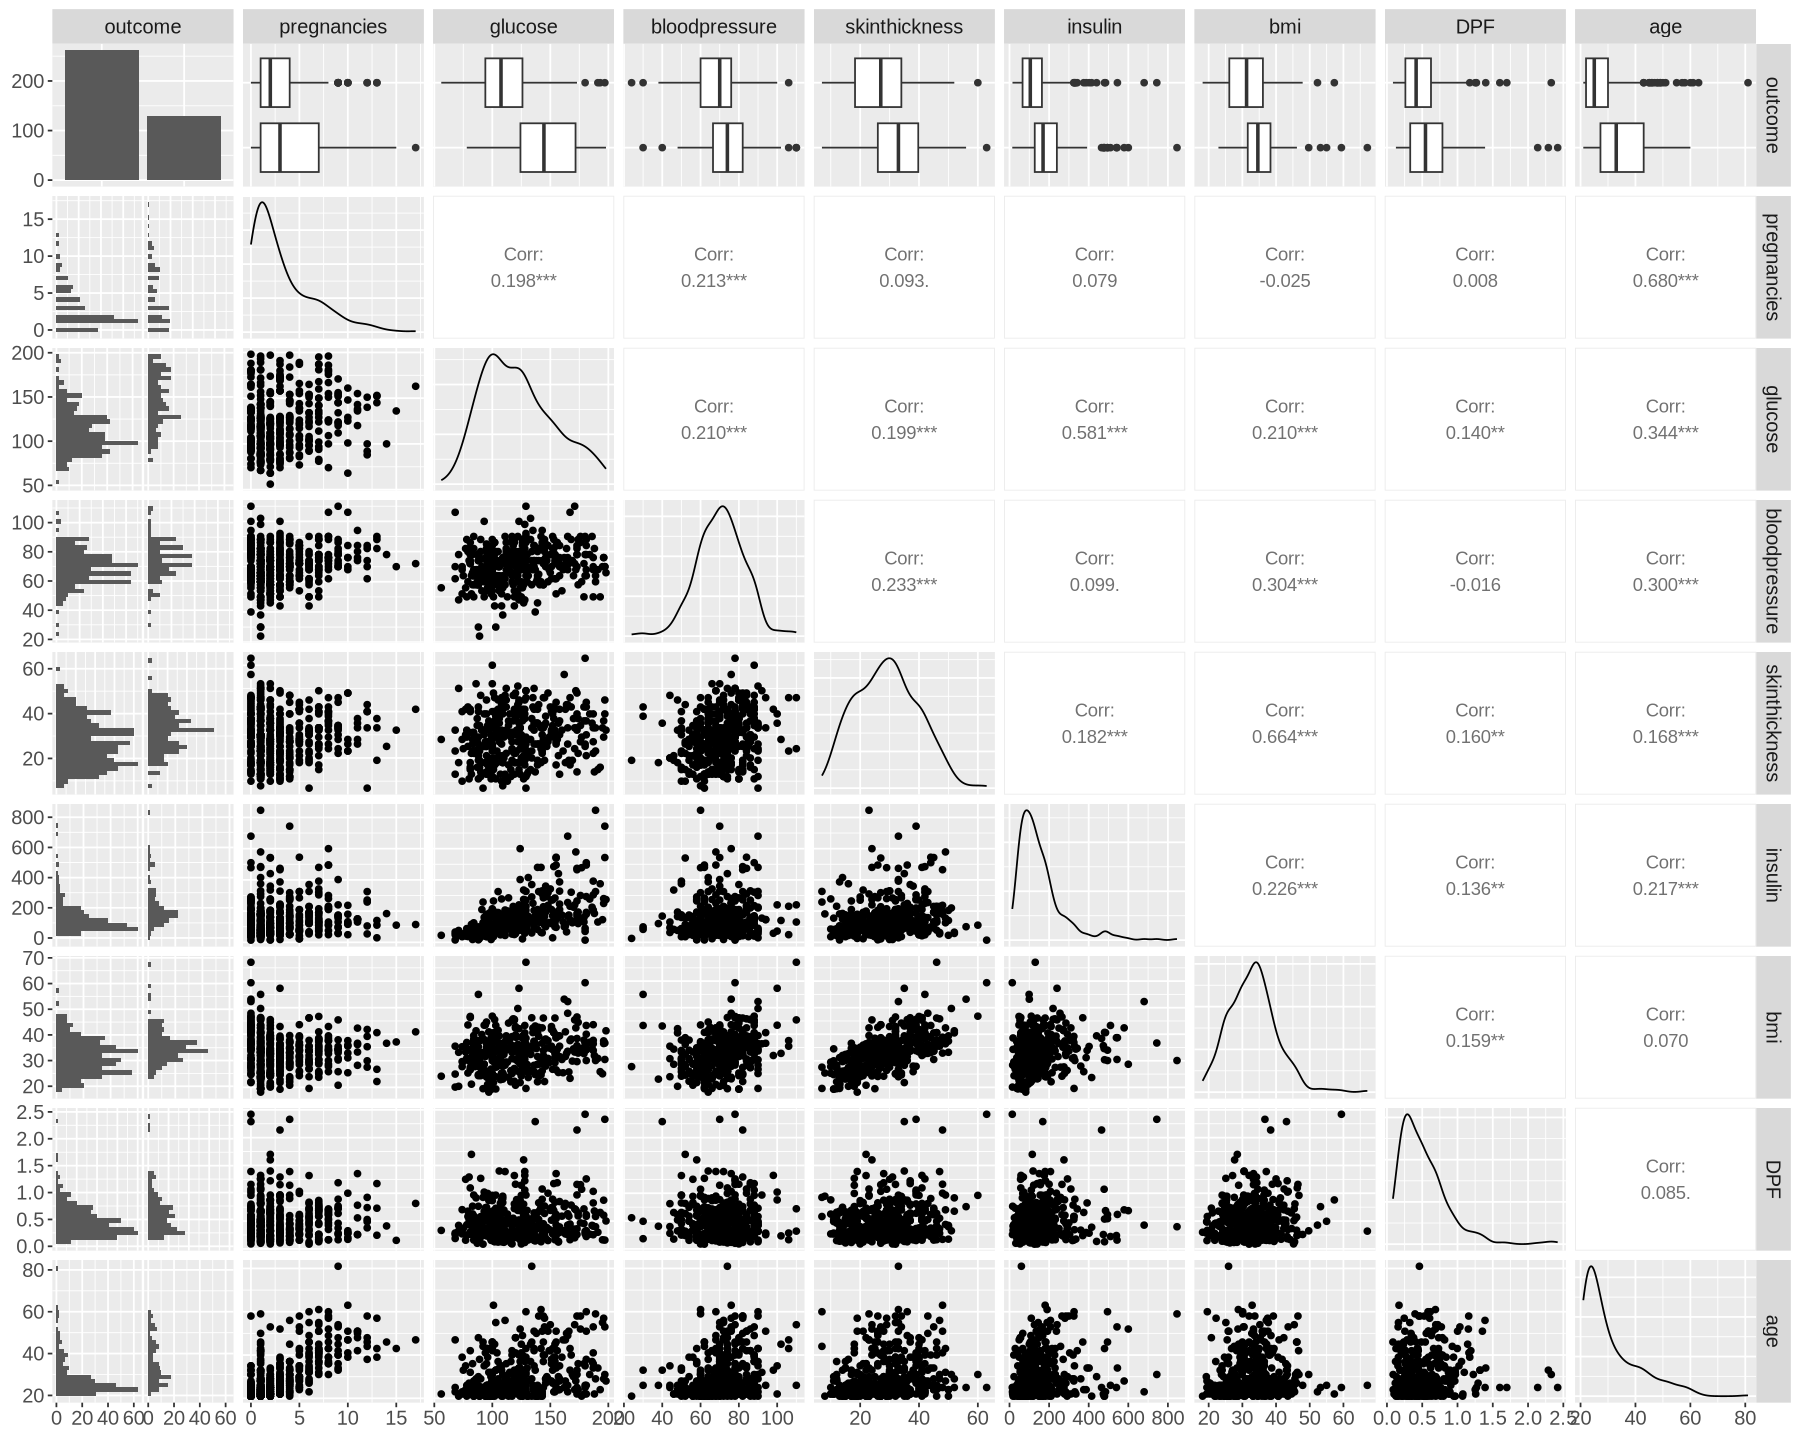

In [4]:
#Pair Plots
options(repr.plot.width = 15, repr.plot.height = 12)

diabetes_pairplots <- diabetes %>%
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))

diabetes_pairplots

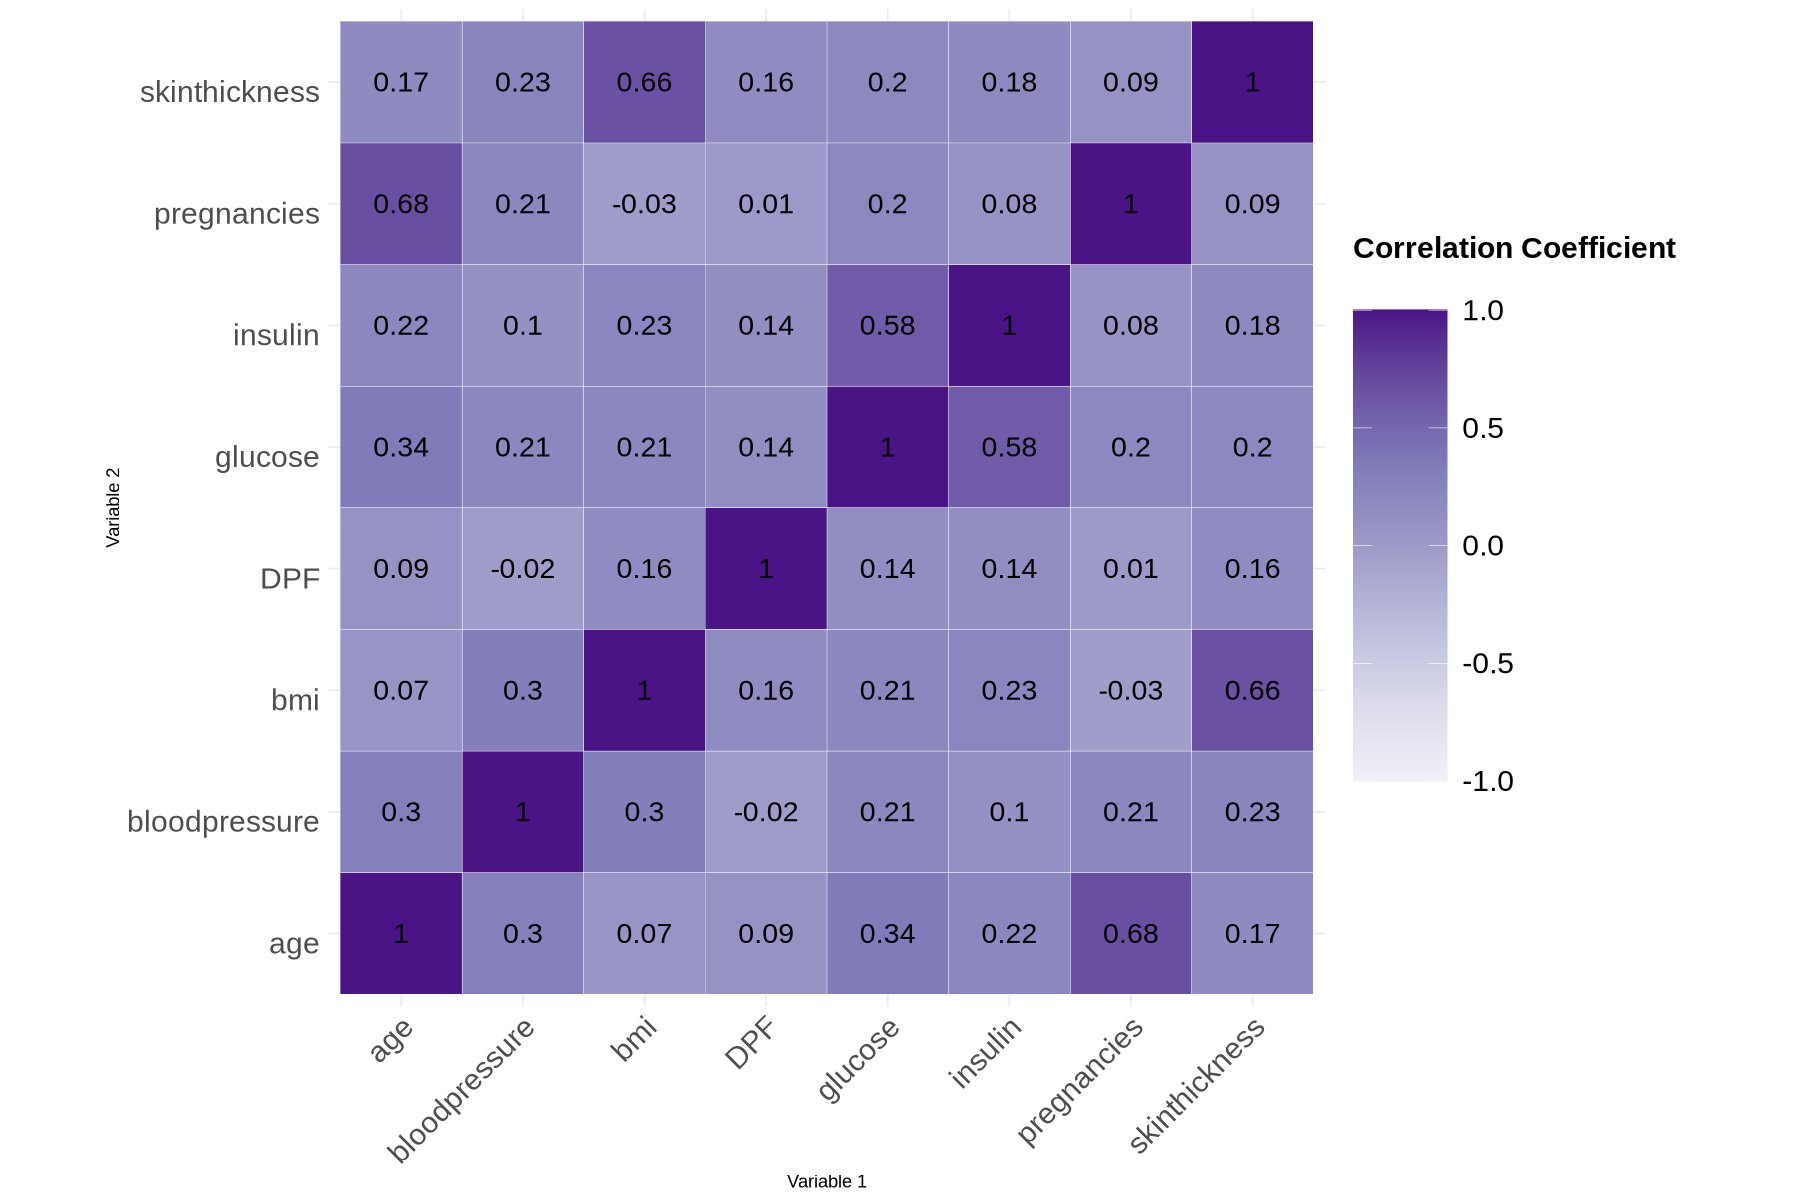

In [5]:
#Correlation Matrix of Input Variables

corr_matrix_diabetes <- diabetes %>%
  select(- outcome) %>% 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

options(repr.plot.width = 15, repr.plot.height = 10)

plot_corr_matrix_diabetes <- corr_matrix_diabetes %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "Purples",
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "Variable 1", y = "Variable 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1, y = var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_diabetes

By visualizing the correlation matrix and pairplots, we can identify which variables are correlated with each other. This map helps us identify potential multicollinearity issues when controlling for multiple variables simultaneously in my future regression analysis. From the map, it seems like Skin Thickness and BMI are highly correlated as well as pregnancies and age. Looking forward, these correlations will help me decide which variables to include or exclude from my regression, ensuring that only relevant variables are considered. 

### Adjusted Question

When controlling for all the other variables, is skin thickness associated with the probability of having diabetes for Pima Indian women over 20?

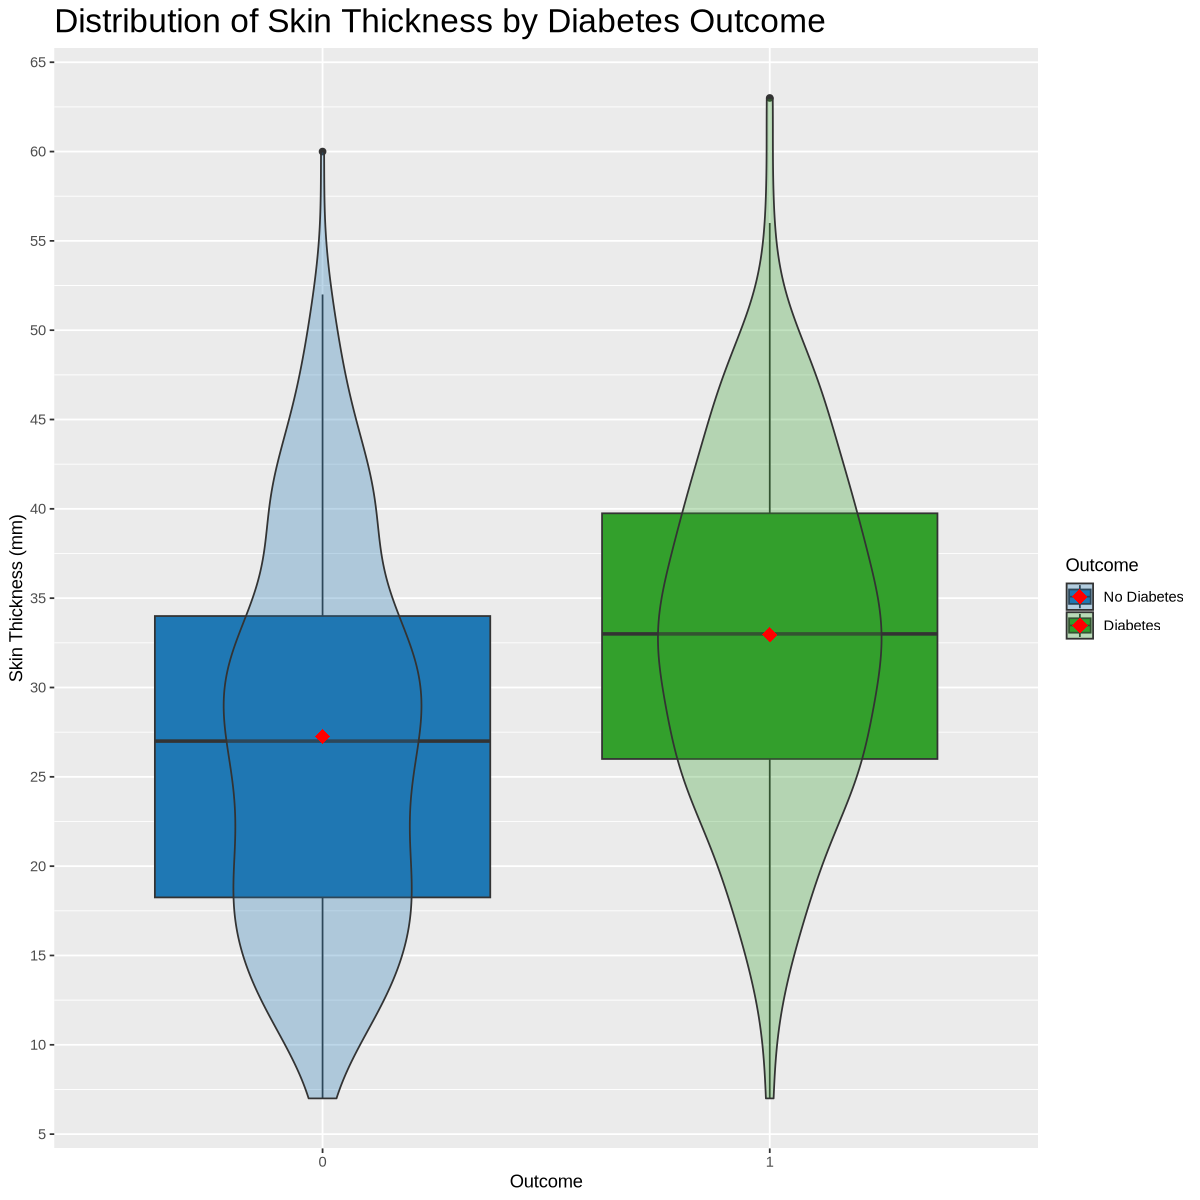

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)

diabetes_boxplot <- ggplot(diabetes, aes(x = outcome, y = skinthickness, fill = outcome)) +
  geom_boxplot() +
  geom_violin(width=0.5, alpha = 0.3) +
  # geom_jitter(shape = 16, position = position_jitter(0.2), alpha = 0.2) + # Add points
  stat_summary(fun = mean, geom = "point", shape = 18, size = 4, color = "red") + # Add mean points
  labs(x = "Outcome", y = "Skin Thickness (mm)", title = "Distribution of Skin Thickness by Diabetes Outcome") +
  scale_fill_manual(values = c("#1f78b4", "#33a02c"), name = "Outcome", labels = c("No Diabetes", "Diabetes")) + 
  scale_y_continuous(breaks = seq(0, 100, by = 5), labels = seq(0, 100, by = 5)) + # Adjust y-axis breaks and labels
  theme(plot.title = element_text(size = 20)) # increase title size

diabetes_boxplot

#violin plot 

The boxplot serves as a visualization for exploring the association between skin thickness and the likelihood of diabetes among Pima Indian women over 20. By segregating the data into diabetic and non-diabetic groups, it is a direct comparison of the distribution of skin thickness between these two groups. I also plotted the mean, which as we can see are very close to the median, which implies that there aren't outliers which pull the mean far away from the median. This comparison enables the identification of potential differences in central tendency and variability in skin thickness, which may indicate an association with diabetes probability. Moreover, the inclusion of the distribution assists in detecting outliers within each group, which is useful in understanding extreme values that could influence the relationship under investigation. The reason I chose the boxplot is becuase of the nature of the response variable output. Becuase it is a dummy variable of either 1 or 0, a scatter plot wouldn't be very useful as all the points would be 1 or 0 and therfore no meaningful analysis could be done from observing the plot. Here however, there is a noticeable difference in the distribution of the skin thickness of those with and without diabetes. While we have not performed statistical analysis yet, this is difference is noticeable. 

# Methods and Plan

#### Methodology and Plan

Having met with my group members and TA overseeing the project, we decided to again pivot our main goal and instead use a logistic regression model to predict the presence of diabetes based on glucose, blood pressure, body mass index, and age. These variables will be used to predict the binary output variable diabetes which will be measured as 1 for having diabetes and 0 if not. 

A logistic regression is highly appropriate for this exploration. First, the outcome variable diabetes is measured on a binary scale. The logistic regression is similar to the linear estimates in the sense that it reflects the weights (coefficients) of each input variable. However, what makes a logistic regression more suitable than linear is that it restricts the output to fall in the range [0,1]. Doing so addresses the needs of our regression and binary output of the diabetes variable. Additionaly, the beta coefficients of the estimated logistic regression have straightforward interpretations. An exponentiated coefficient beta can be interpreted as the ((beta*100) - 100)% change in the odds of the outcome variable. This allows us to compare the impact of different predictor variables in our logistic regression. 

In order to measure the performance of the estimated logistic regression I plan to use 2 methods of evaluation:

1) F1 Score: This is a balanced measure of both precison and recall. The F1 score is out of the scope of this class but from what I can discern, precision is defined as how well the model predicts true positives out of all true predictions and recall is the number of true positives out of all actual positive instances. By incorporating both, the F1 score will be high only if both precision and recall are high. Hence, The F1 score takes both false positives and false negatives into account, making it useful for evaluating the overall performance of our classification model.

2) ROC Curve (AUC): The Receiver Operating Characteristic curve is a graphical representation that illustrates the performance of a binary classification model across different threshold values. It plots the true positive rate (TPR) against the false positive rate (FPR) for various threshold values. This will help us visualize the accuracy of our predictions. The area under the curve (AUC) quantifies the area under the ROC curve. A perfect classifier would have an AUC of 1, while a random classifier would have an AUC of 0.5. The higher the AUC, the better the classifier's ability to distinguish between the positive and negative classes.


#### Model Assumptions

Logistic regression assumes there is a binary outcome variable which holds for our dataset. Diabetes is a binary variable. Another assumption is that the observations are identically and independently distributed which we will have to assume is true as we did not participate in any of the data collection of this dataset. Logistic regression also assumes that there is little or no multicollinearity among the independent variables. To address multicollinearity, it may be necessary to remove one of the correlated variables identified in the correlation map above or by using techniques such as ridge/LASSO regression. The variables listed earlier reflect preliminary choices to omit a few correlated varibales like pregnacies and age as well as glucose and insulin. In our final project the choice of variables may be different. The model also tends to provide more accurate results when the number of observations is large and there are minimal to no outliers in the data. 

#### Limitations and Considerations

